## Stock Price Prediction (Analytics Vidhya Competition)
This notebook uses ARIMA model to predict stock price. The predictions produce a score of 2.93 on the public leaderboard. 

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/hacklive-4/SampleSubmission.csv
/kaggle/input/hacklive-4/Test.csv
/kaggle/input/hacklive-4/Train.csv


### Load Data

In [2]:
train = pd.read_csv('../input/hacklive-4/Train.csv',index_col='ID')
test = pd.read_csv('../input/hacklive-4/Test.csv',index_col='ID')
sub = pd.read_csv('../input/hacklive-4/SampleSubmission.csv',index_col='ID')

### Data Exploration

In [3]:
train

,stock,Date,Open,High,Low,Close,holiday,unpredictability_score
ID,,,,,,,,
id_0,0,2017-01-03,82.9961,82.7396,82.9144,82.8101,1,7
id_1,0,2017-01-04,83.1312,83.1669,83.3779,82.9690,0,7
id_2,0,2017-01-05,82.6622,82.7634,82.8984,82.8578,0,7
id_3,0,2017-01-06,83.0279,82.7950,82.8425,82.7385,0,7
id_4,0,2017-01-09,82.3761,82.0828,82.1473,81.8641,0,7
...,...,...,...,...,...,...,...,...
id_77616,102,2019-10-25,129.7152,130.4687,130.7243,131.0068,0,6
id_77617,102,2019-10-28,131.2933,131.5415,132.3108,131.8185,0,6
id_77618,102,2019-10-29,131.1130,131.6313,131.7669,132.0440,0,6


In [4]:
test

,stock,Date,holiday,unpredictability_score
ID,,,,
id_713,0,2019-11-01,0,7
id_714,0,2019-11-04,0,7
id_715,0,2019-11-05,0,7
id_716,0,2019-11-06,0,7
id_717,0,2019-11-07,0,7
...,...,...,...,...
id_77657,102,2019-12-24,0,6
id_77658,102,2019-12-26,1,6
id_77659,102,2019-12-27,0,6


The data consists of stock prices of 103 stocks for a period of almost 2 years. We are required to predict closing price for the next 41 days. We are given data on Open, High, Low and Close prices along with a score for volatility of the stocks and also the data on holidays.

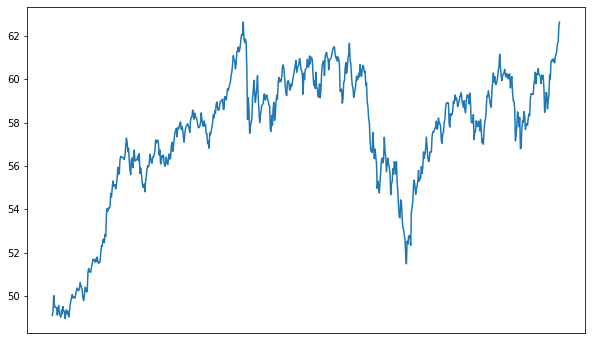

In [7]:
def plot_stock_price(stock_label):
    plt.figure(figsize=(10,6))
    plt.plot(train[train['stock']==stock_label]['Close'].values)
    plt.xticks([])
    plt.show()
plot_stock_price(100)

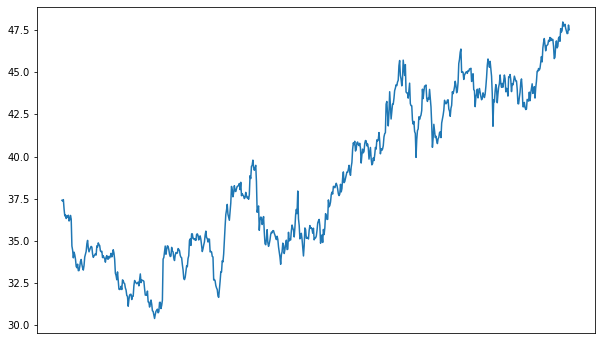

In [8]:
plot_stock_price(68)

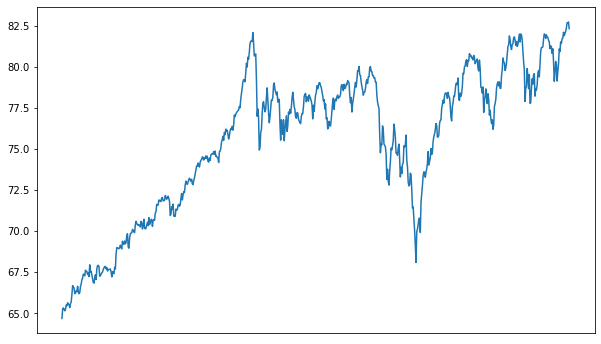

In [9]:
market_price = train.groupby('Date')['Close'].mean()
plt.figure(figsize=(10,6))
plt.plot(market_price.values)
plt.xticks([])
plt.show()

It is mostly a bull market. For a brief period of time most of the stocks went down and they picked up very quickly.

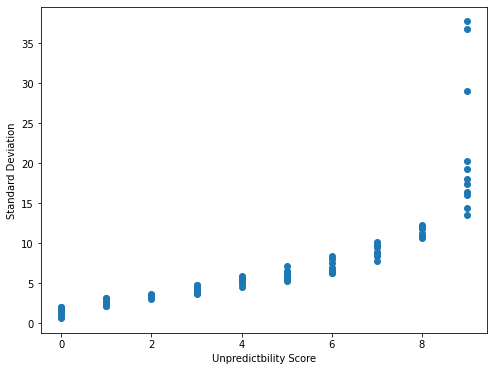

In [10]:
std = []
unpredict = []
for st in range(103):
    std.append(train[train['stock']==st]['Close'].std())
    unpredict.append(train[train['stock']==st]['unpredictability_score'].mean())
plt.figure(figsize=(8,6))
plt.scatter(unpredict,std)
plt.xlabel('Unpredictbility Score')
plt.ylabel('Standard Deviation')
plt.show()

The above figure shows the plot of standard deviation of the stocks versus the unpredictability score. As expected they are positively correlated.

### Model training and validation
A variety of models are used for time series predictions. Some of the popular ones are ARIMA, VARMA, SARIMA, LSTM, GRU, CNN and HES(Holts Exponential Smoothing). ARIMA takes three hyperparameters. One coeeficient for auto regression, differencing and moving average each. The auto regression coeefficient could be decided based on acf and pacf plots. There are methods to decide other coefficients. Since there are a large number of stocks it would be tedious to do that. Hence a part of the time series is kept for validation. Grid search is performed for all the three hyperparameters and the one which results in the least error on the validation set is used to train on the entire time series and predictions are made. Also some of the orders could result in Convergence issues, some would not be suitable for training arima. They need to be taken care of while performing the grid search. Holiday column is an exogeneous variable (available for both train and test set). This is also passed to the model.

In [11]:
import warnings
warnings.filterwarnings('error',category=statsmodels.tools.sm_exceptions.HessianInversionWarning)
warnings.filterwarnings('error',category=statsmodels.tools.sm_exceptions.ConvergenceWarning)
warnings.filterwarnings('error',category=RuntimeWarning)
warnings.filterwarnings('ignore',category=UserWarning)

In [12]:
def train_arima(ts,exog,order,verbose=1):
    """
    ts - time series to train on
    exog - exogeneous variable of length same as that of ts
    order - tuple of size 3 with coefficients corresponding to AR, I and MA parts of the model
    verbose - 1 or 0 whether to print the info while running or not

    returns fit model which can forecast the values
    """
    model = statsmodels.tsa.arima.model.ARIMA(endog=ts, exog=exog, order=order)
    try:
        model_fit = model.fit()
        return model_fit
    except:
        if verbose:
            print('     The order is not valid for fitting the model')
        return None

In [13]:
def split_time_series(ts,train_size):
    """
    ts - time series which needs to be split (numpy array)
    train_size - size of the training data (0 to 1)

    returns 2 time series (train_ts,val_ts)
    """
    split_ind = int(train_size*ts.shape[0])
    train_ts,val_ts = ts[:split_ind],ts[split_ind:]
    return (train_ts,val_ts)

In [14]:
def get_forecast_error(ts,ts_pred):
    return np.round(np.sqrt(mean_squared_error(ts,ts_pred)),6)

In [15]:
def validate_arima_model(ts,exog,param_grid,train_size=0.8,verbose=1):
    """
    ts - time series available for training and validation (numpy array)
    exog - exogeneous variable of length same as that of ts
    param_grid - dictionary of arima model orders. Has keys - (p,q,r) Ex: {'p':[1,2,3],'q':[0,1,2],'r':[2,3,4]}
    returns best (p,q,r)
    """
    num_models = len(param_grid['p'])*len(param_grid['q'])*len(param_grid['r'])
    if verbose:
        print('Total Number of models to be trained =',num_models)
        print('')

    train_ts,val_ts = split_time_series(ts,train_size)
    train_exog,val_exog = split_time_series(exog,train_size)
    forecast_steps = val_ts.shape[0]
    orders_errors = []
    best_error = np.inf
    for p in param_grid['p']:
        for q in param_grid['q']:
            for r in param_grid['r']:
                if verbose:
                    print(f'The model order = ({p},{q},{r}):')
                model_fit = train_arima(train_ts,exog=train_exog,order=(p,q,r),verbose=0)
                if model_fit:
                    val_forecast = model_fit.forecast(forecast_steps,exog=val_exog)
                    error = get_forecast_error(val_ts,val_forecast)
                    if verbose:
                        print('    The error obtained = {:.4f}'.format(error))
                    if error<best_error:
                        best_error = error
                        best_order = (p,q,r)

                    orders_errors.append(((p,q,r),error))

                if verbose:
                    print('')
    if verbose:
        print(f'Best order =',best_order)
        print('Best error = {:.4f}'.format(best_error))
    return best_order,best_error,orders_errors

In [16]:
def Predict_stockprice():
    """
    st - Stock number
    the function takes stock data and performs arima forecasting followed by prediction on test data
    """
    best_orders = {}
    least_errors = {}
    pred_close_price = np.array([])
    for st in range(103):
        print('Stock label =',st)
        ts = train[train['stock']==st]['Close'].values
        exog = train[train['stock']==st]['holiday'].values 
        param_grid = {'p':[1,2,3],'q':[0,1,2],'r':[0,1,2,3]}
        best_order,best_error,orders_errors = validate_arima_model(ts,exog,param_grid,train_size=0.8,verbose=0)
        best_orders[st] = best_order
        least_errors[st] = best_error
        model_fit = train_arima(ts,exog,best_order,verbose=0)
        k = 1
        if model_fit==None:
            orders_errors = sorted(orders_errors,key=lambda x:x[1],reverse=False)
        while model_fit==None:
            model_fit = train_arima(ts,exog,orders_errors[k][0],verbose=0)
            best_orders[st] = orders_errors[k][0]
            least_errors[st] = orders_errors[k][1]
            k+=1
        print('     Best order =',best_orders[st])
        print('     Least error =',least_errors[st])
        test_exog = test[test['stock']==st]['holiday'].values
        steps = test_exog.shape[0]
        forecasts = model_fit.forecast(steps,exog=test_exog)
        pred_close_price = np.append(pred_close_price,forecasts)
        print('')

    return pred_close_price,best_orders,least_errors

output = Predict_stockprice()

Stock label = 0
     Best order = (3, 2, 0)
     Least error = 5.47657

Stock label = 1
     Best order = (2, 2, 3)
     Least error = 0.321214

Stock label = 2
     Best order = (3, 2, 0)
     Least error = 1.059714

Stock label = 3
     Best order = (3, 1, 0)
     Least error = 1.978429

Stock label = 4
     Best order = (2, 2, 0)
     Least error = 5.002416

Stock label = 5
     Best order = (2, 0, 1)
     Least error = 15.34706

Stock label = 6
     Best order = (2, 2, 1)
     Least error = 1.515244

Stock label = 7
     Best order = (2, 1, 2)
     Least error = 3.006667

Stock label = 8
     Best order = (2, 1, 3)
     Least error = 0.538458

Stock label = 9
     Best order = (2, 1, 0)
     Least error = 4.244209

Stock label = 10
     Best order = (3, 2, 3)
     Least error = 0.638248

Stock label = 11
     Best order = (3, 2, 1)
     Least error = 1.611962

Stock label = 12
     Best order = (1, 1, 3)
     Least error = 6.528095

Stock label = 13
     Best order = (1, 1, 1)
    

In [17]:
sub['Close'] = output[0]

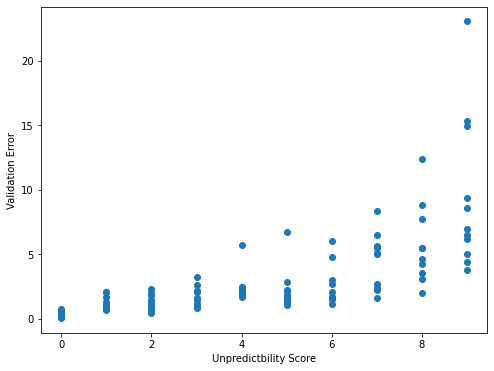

In [18]:
plt.figure(figsize=(8,6))
unpredict = train.groupby('stock')['unpredictability_score'].mean().values
errors = list(output[2].values())
plt.scatter(unpredict,errors)
plt.xlabel('Unpredictbility Score')
plt.ylabel('Validation Error')
plt.show()

The plot shows how the validation error increases with increase in stock volatility.

In [19]:
def plot_validation_predictions(st,order_dict):
    order = order_dict[st]
    ts = train[train['stock']==st]['Close'].values
    exog = train[train['stock']==st]['holiday'].values  
    train_size=0.8
    train_ts,val_ts = split_time_series(ts,train_size)
    train_exog,val_exog = split_time_series(exog,train_size)
    forecast_steps = val_ts.shape[0]
    model_fit = train_arima(train_ts,exog=train_exog,order=order,verbose=0)
    val_forecast = model_fit.forecast(forecast_steps,exog=val_exog)
    plt.figure(figsize=(8,6))
    start = len(ts)-len(val_forecast)
    end = len(ts)
    plt.plot(ts,label='True')
    plt.plot(list(range(start,end)),val_forecast,label='Predicted')
    plt.legend()
    plt.show()

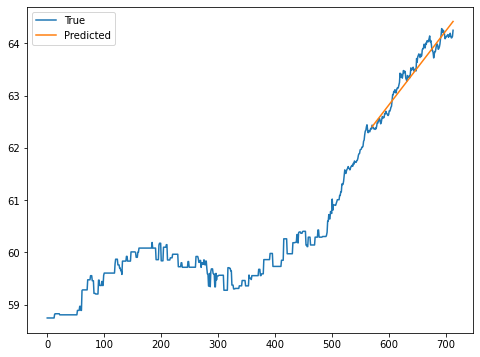

In [20]:
plot_validation_predictions(15,output[1])

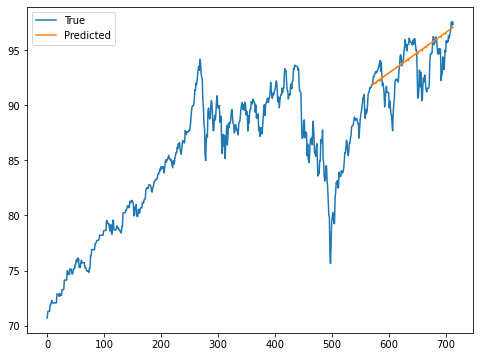

In [21]:
plot_validation_predictions(78,output[1])

The model has tried to find a linear fit and succeded to some extent

In [23]:
sub.to_csv('Submission_file_ARIMA_dps_335.csv')